In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler

In [30]:
# Using AAPL, MSI, SBUX stocks
def get_data():
    df = pd.read_csv('data/aapl_msi_sbux.csv')
    return df.values

def get_scaler(env):
    # return scikit-learn scaler object to scale the states
    # Note: you could also populate the replay buffer here

    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break

    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [31]:
class LinearModel:
    # Linear regression model
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)

        self.vW = 0
        self.vb = 0
        self.losses = []

    def predict(self, X):
        # make sure that X is N x D
        assert(len(X.shape) == 2)
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
        # make sure X is N x D
        assert(len(X.shape) == 2)

        # the loss values are 2-D
        # normally we should divide by N only but now we divide by N x K
        num_values = np.product(Y.shape)

        # do one step of gradient descent, we multiply by 2 to get the exact gradient
        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values

        # update momentum terms
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb

        # update params
        self.W += self.vW
        self.b += self.vb

        mse = np.mean((Yhat - Y) ** 2)
        self.losses.append(mse)

    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)

In [40]:
class MultiStockEnv:
    # A 3-stock trading environment.
    # State: Vector of size 7 (n_stock * 2 + 1)
    #   - # shares of stock 1 owned
    #   - # shares of stock 2 owned
    #   - # shares of stock 3 owned
    #   - price of stock 1 (using only daily close price)
    #   - price of stock 2
    #   - price of stock 3
    #   - cash owned (can be used to purchase more stocks)
    # Action: categorical variable with 27 (3^3) possibilities
    #   - for each stock, you can:
    #   - 0 = sell
    #   - 1 = hold
    #   - 2 = buy
    def __init__(self, data, initial_investment=20000):
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attr
        self.initial_investment = initial_investment
        self.curr_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        # action permutations
        # returns a nested list with elements like:
        # [0, 0, 0]
        # [0, 0, 1]
        # [0, 0, 2]
        # [0, 1, 0]
        # etc.
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()

    def reset(self):
        self.curr_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.curr_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()

    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()

        # update price, i.e. go to the next day
        self.curr_step += 1
        self.stock_price = self.stock_price_history[self.curr_step]

        # perform the trade
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in portfolio value
        reward = cur_val - prev_val

        # done if we have run out of data
        done = self.curr_step == self.n_step - 1

        # store the current value of the portfolio here
        info = {'cur_val': cur_val}

        # conform to the GYM API
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs

    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2, 1, 0] means:
        # buy first, hold second, sell third
        action_vec = self.action_list[action]

        # determine which stocks to buy or sell
        sell_index = []
        buy_index = []
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:
            # When buying we will loop through each stock we want to buy
            # and buy one share at a time until we run out of cash
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [41]:
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95 # discount rate
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [42]:
def play_one_episode(agent, env, is_train):
    # note: after transforming states are already 1xD
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        state = next_state

    return info['cur_val']

In [43]:
models_folder = 'linear_rl_trader_models'
rewards_folder = 'linear_rl_trader_rewards'
num_episodes = 2000
batch_size = 32
initial_investment = 20000

maybe_make_dir(models_folder)
maybe_make_dir(rewards_folder)

data = get_data()
n_timesteps, n_stocks = data.shape

n_train = n_timesteps // 2

train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

# store the final value of the portfolio
portfolio_value = []

episode: 1/2000, episode env value: 39371.74, duration:0:00:00.119998
episode: 2/2000, episode env value: 33207.12, duration:0:00:00.085997
episode: 3/2000, episode env value: 28879.75, duration:0:00:00.084001
episode: 4/2000, episode env value: 33684.37, duration:0:00:00.091000
episode: 5/2000, episode env value: 29553.99, duration:0:00:00.096998
episode: 6/2000, episode env value: 33428.53, duration:0:00:00.099003
episode: 7/2000, episode env value: 34812.31, duration:0:00:00.101999
episode: 8/2000, episode env value: 36971.46, duration:0:00:00.095002
episode: 9/2000, episode env value: 34671.66, duration:0:00:00.099998
episode: 10/2000, episode env value: 35759.64, duration:0:00:00.101003
episode: 11/2000, episode env value: 37127.66, duration:0:00:00.102337
episode: 12/2000, episode env value: 36308.99, duration:0:00:00.105299
episode: 13/2000, episode env value: 35056.75, duration:0:00:00.102002
episode: 14/2000, episode env value: 39810.37, duration:0:00:00.091998
episode: 15/200

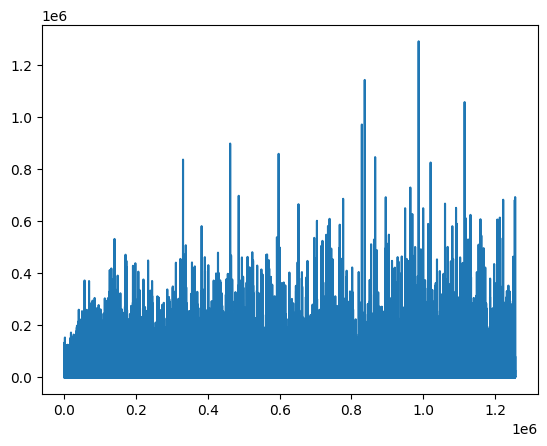

In [44]:
# train
for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, "train")
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode env value: {val:.2f}, duration:{dt}")
    portfolio_value.append(val)

agent.save(f'{models_folder}/linear.npz')
with open(f'{models_folder}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
plt.plot(agent.model.losses)
plt.show()


In [45]:
# save rewards for train
np.save(f'{rewards_folder}/train.npy', portfolio_value)

In [48]:
# plot reward
def plotReward(type):
    a = np.load(f'linear_rl_trader_rewards/{type}.npy')
    print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}")

    if type == 'train':
        plt.plot(a)
    else:
        plt.hist(a, bins=20)
    plt.title(type)
    plt.show()

average reward: 50510.51, min: 24765.40, max: 83620.89


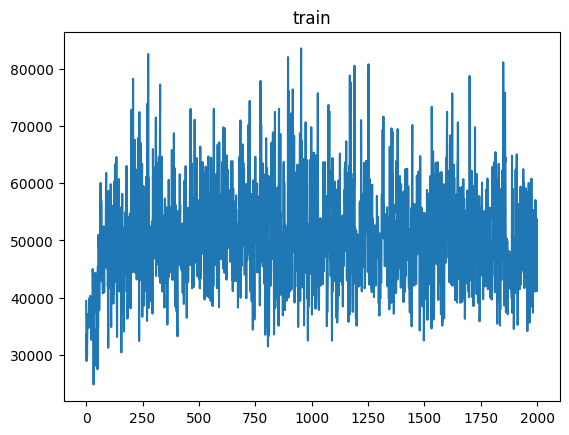

In [49]:
plotReward("train")

average reward: 50510.51, min: 24765.40, max: 83620.89


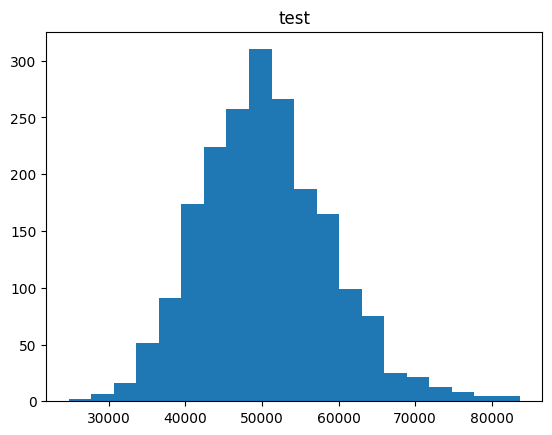

In [51]:
# testing cell
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# remake the env with test data
env = MultiStockEnv(test_data, initial_investment)
agent.epsilon = 0.01

agent.load(f'{models_folder}/linear.npz')

# save rewards for testing
np.save(f'{rewards_folder}/test.npy', portfolio_value)

plotReward("test")